# Capítulo X - Método Cross-Entropy


Você pode rodar este notebook no Colab ou localmente. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/capExtra/capX-crossentropy.ipynb) 

Para rodar localmente, primeiro, baixe todo o repositório do github: https://github.com/pablo-sampaio/rl_facil.

## 1. Configurações Iniciais

### Cria Diretório para Experimentos

In [1]:
!mkdir results

J� existe uma subpasta ou um arquivo results.


### Configurações Dependentes do Sistema

Rode a célula abaixo, mesmo sem estar no Colab.

In [2]:
import sys
from IPython.display import clear_output

if 'google.colab' in sys.modules:
    !pip install gym
    !pip install gym[box2d]
    !pip install optuna

    # para salvar videos
    !apt-get install -y xvfb x11-utils
    !pip install pyvirtualdisplay==0.2.*
    !apt-get install ffmpeg

    from pyvirtualdisplay import Display
    global display
    display = Display(visible=False, size=(1400, 900))
    _ = display.start()

    !git clone https://github.com/pablo-sampaio/rl_facil
    clear_output()

    !mv /content/rl_facil/cap04/* /content/
    !mv /content/rl_facil/cap05/* /content/
    !mv /content/rl_facil/cap06/* /content/

else:
    # atenção: para Windows apenas! 
    # se estiver no Linux, troque por "copy" por "cp" e mude a barra
    !copy ..\cap04\util_*.py .


..\cap04\util_experiments.py
..\cap04\util_plot.py
        2 arquivo(s) copiado(s).


### Configurações para Exibir Video

In [3]:
# ideias adaptadas de : https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google
from base64 import b64encode
from IPython.display import HTML
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  html_code = f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
  return HTML(html_code)

### Imports Principais

Import algoritmos, ambientes e outros módulos.

In [8]:
import gym
import numpy as np
import optuna

from util_experiments import repeated_exec
from util_plot import plot_result, plot_multiple_results

#from montecarlo_v2 import run_montecarlo2
#from qlearning import run_qlearning
#from expected_sarsa import run_expected_sarsa
from models_torch import test_policy
from crossentropy_method_v1 import run_crossentropy_method1, PolicyModelCrossentropy

## 2. Rodando o Método Cross-Entropy

In [15]:
#ENV_NAME, rmax = "CartPole-v1", 500
ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 300
#ENV_NAME, rmax = "MountainCar-v0", 0  # resultados ruins
ENV = gym.make(ENV_NAME)

EPISODES   = 400    # total de episódios
BATCH_SIZE = 5      # quantidade de episódios executados por época de treinamento
PROPORTION = 0.2    # percentual dos episódios (do batch) que serão selecionados

policy_model = PolicyModelCrossentropy(ENV.observation_space.shape[0], [512], ENV.action_space.n, lr=0.005)
returns, policy = run_crossentropy_method1(ENV, EPISODES, BATCH_SIZE, PROPORTION)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))


Últimos episódios do treinamento: media = -137.4 , desvio padrao = 18.172506706560878


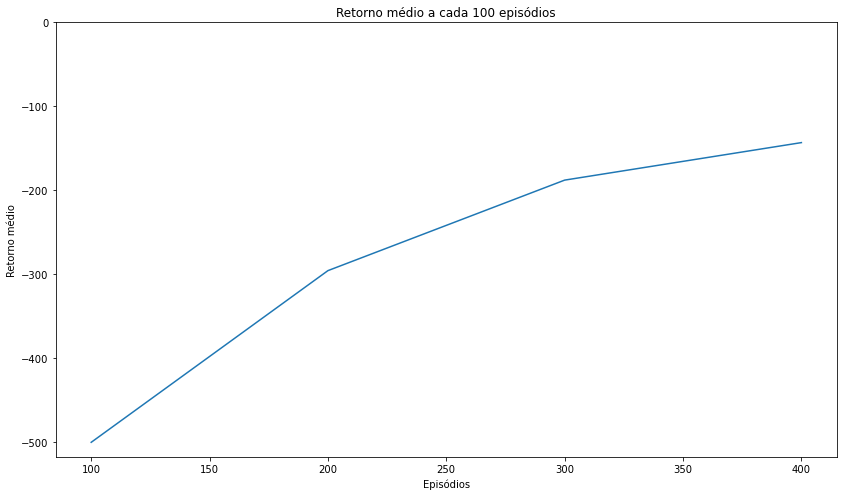

Nenhum arquivo salvo.


In [16]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns, rmax, None)

In [ ]:
# Faz alguns testes com o modelo de forma DETERMINÍSTICA e salva o vídeo em arquivo
video = VideoRecorder(ENV, "politica-treinada.mp4")
test_policy(ENV, policy, True, 5, render=False, videorec=video)

In [ ]:
render_mp4("politica-treinada.mp4")

## 3. Experimentos


### 3.1 Parâmetros do Cross-Entropy

Abaixo, mostramos experimentos variando os dois parâmetros mais diretos do método:
- o tamanho de batch (de episódios)
- a proporção dos episódios selecionados

***Atenção***: de forma geral, os resultados variam muito, porque dependem da inicialização da rede neural, que é aleatória. Para resultados mais confiáveis, use um número mais alto de repetições do que estamos usando abaixo. Tente com algumas *dezenas*.

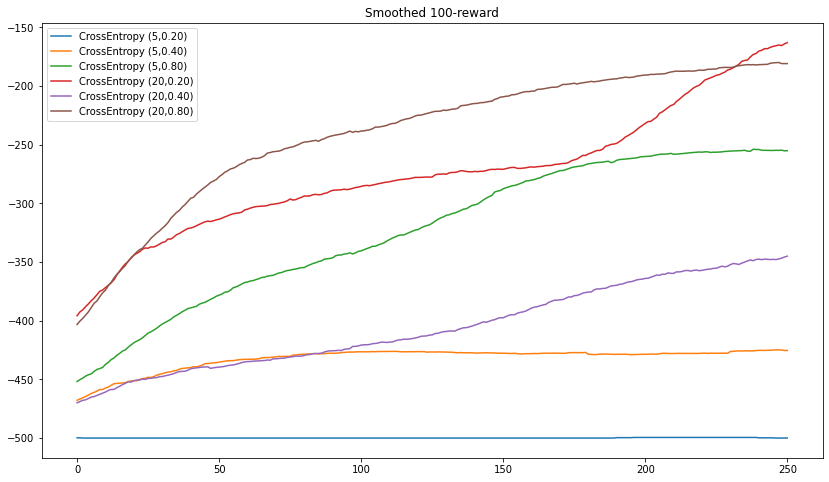

Summary for CrossEntropy (5,0.20)
 - sum rewards (all episodes): -149965.2

Summary for CrossEntropy (5,0.40)
 - sum rewards (all episodes): -130563.8

Summary for CrossEntropy (5,0.80)
 - sum rewards (all episodes): -98657.0

Summary for CrossEntropy (20,0.20)
 - sum rewards (all episodes): -83022.0

Summary for CrossEntropy (20,0.40)
 - sum rewards (all episodes): -121828.0

Summary for CrossEntropy (20,0.80)
 - sum rewards (all episodes): -74963.4



In [18]:
ENV = gym.make("Acrobot-v1")
NUM_EPISODES = 300

results = []

for batch_size in [5, 20]:
    #results = []
    for proportion in [1/5.0, 2/5.0, 4/5.0]:
        results.append( repeated_exec(5, f"CrossEntropy ({batch_size}; {proportion:.2f})", run_crossentropy_method1, ENV, NUM_EPISODES, batch_size, proportion) )
        clear_output()
    #plot_multiple_results(results, cumulative=False, x_log_scale=False)

plot_multiple_results(results, cumulative=False, x_log_scale=False)


### 3.2 Parâmetros da Rede Neural (da Política)

Você também pode variar todos os parâmetros da rede neural: quantidade de camadas, taxa de aprendizagem, etc.

In [9]:
ENV = gym.make("Acrobot-v1")

NUM_EPISODES = 300
BATCH_SIZE   = 20
PROPORTION   = 0.8

print("Observation Space - ", ENV.observation_space.shape)
print("Observation Space - shape", ENV.observation_space.shape)
print("Action Space - ", ENV.action_space)
print("Action Space - number of actions - ", ENV.action_space.n)

Observation Space -  (6,)
Observation Space - shape (6,)
Action Space -  Discrete(3)
Action Space - number of actions -  3


d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


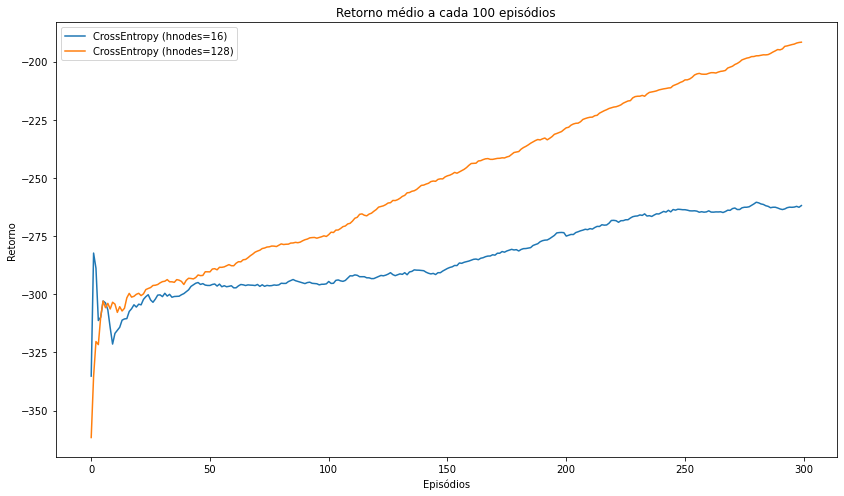

Summary for CrossEntropy (hnodes=16)
 - sum rewards (all episodes): -83094.20000000001

Summary for CrossEntropy (hnodes=128)
 - sum rewards (all episodes): -69604.2



In [13]:
results = []

for hidden_layer_size in [16, 128]:
    policy_model = PolicyModelCrossentropy(ENV.observation_space.shape[0], [hidden_layer_size], ENV.action_space.n, lr=0.01)
    results.append( repeated_exec(5, f"CrossEntropy (hnodes={hidden_layer_size})", run_crossentropy_method1, ENV, NUM_EPISODES, BATCH_SIZE, PROPORTION, policy_model) )
    clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)